In [90]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ParseData
import scipy.stats as stats
import numpy as np
import pytablewriter
import matplotlib
import matplotlib.patches as mpatches
import importlib
importlib.reload(ParseData)

%matplotlib notebook

Data = ParseData.GetData()

['Gunshot' 'Physical force' 'Restraint' 'Other' 'Unknown']


<IPython.core.display.Javascript object>


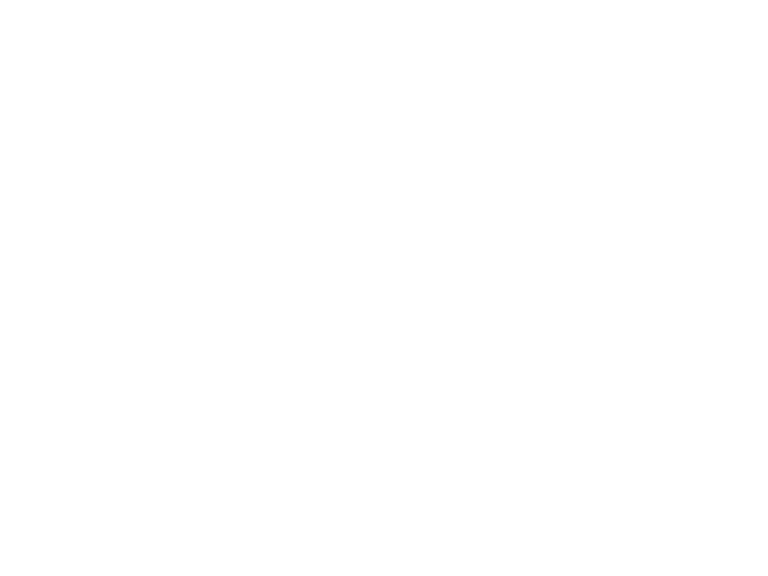

In [49]:
Weaopn_Type=Data.CA_PoliceKillings.groupby('CAUSE DEATH').count()['AGE'].sort_values()
print(Data.CA_PoliceKillings['CAUSE DEATH'].unique())

fig,ax=plt.subplots(1,1)
ax.set_title('Cause of Death (n= '+str(Data.CA_PoliceKillings.count()['NAME FIRST'])+')',loc='left')
ax.pie(Weaopn_Type.values,labels=Weaopn_Type.index,
    autopct='%1.1f%%')
plt.tight_layout()
plt.savefig('Content/CA_CauseofDeath.png')


In [50]:
print(Data.CBC_Data_Original.groupby('RACE').count()['VICTIM ID'],'\n'
      ,Data.CBC_Data_Original.groupby('RACE').count()['VICTIM ID'].sum())

print(Data.CBC_Data_Original.loc[Data.CBC_Data_Original['NAME FIRST']=='Unknown'].count()['VICTIM ID'])
print(Data.CBC_Data_Original.loc[Data.CBC_Data_Original['CAUSE DEATH']=='Unknown'].count()['VICTIM ID'])
print(Data.CBC_Data_Original.loc[Data.CBC_Data_Original['ARMED TYPE']=='Unknown'].count()['VICTIM ID'])
print(Data.CBC_Data_Original.columns)

# print(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']=='CBC Deadly Force'].groupby('RACE').count()['VICTIM ID'])

RACE
Arab                5
Asian              16
Black              48
Indigenous         90
Latin American      3
Other               5
South Asian        12
Unknown           136
White             239
Name: VICTIM ID, dtype: int64 
 554
45
22
39
Index(['VICTIM ID', 'DATE', 'NAME FIRST', 'NAME LAST', 'NAME MIDDLE',
       'NICKNAME', 'AGE', 'GENDER', 'RACE', 'PROV', 'POLICE SERVICE',
       'CAUSE DEATH', 'ARMED TYPE', 'PICTURE SOURCE', 'SUMMARY'],
      dtype='object')


In [51]:
# print()
# print(Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
#                                   (Data.CA_PoliceKillings['CAUSE DEATH']!='Gunshot')&
#                                   (Data.CA_PoliceKillings.index>='2020-07-01')),
#                                  ['CAUSE DEATH','DATA SOURCE','Link']].values)

Total Police Killings in Canada: Jan 2000 - June 2020: 600
50
Missing Recrods in CBC data:  0
Incidetns since CBC data published:  0
(21,) (18,)
DATE
2004-01-01     1
2005-01-01     0
2006-01-01     0
2007-01-01     0
2008-01-01     0
2009-01-01     0
2010-01-01     0
2011-01-01     1
2012-01-01     0
2013-01-01     0
2014-01-01     0
2015-01-01     0
2016-01-01     0
2017-01-01     0
2018-01-01     0
2019-01-01     2
2020-01-01    13
2021-01-01     8
Name: PROV, dtype: int64
LinregressResult(slope=1.1467532467532466, intercept=-2284.9740259740256, rvalue=0.8590892513304673, pvalue=6.152538693776463e-07, stderr=0.15673900076897349)


<IPython.core.display.Javascript object>


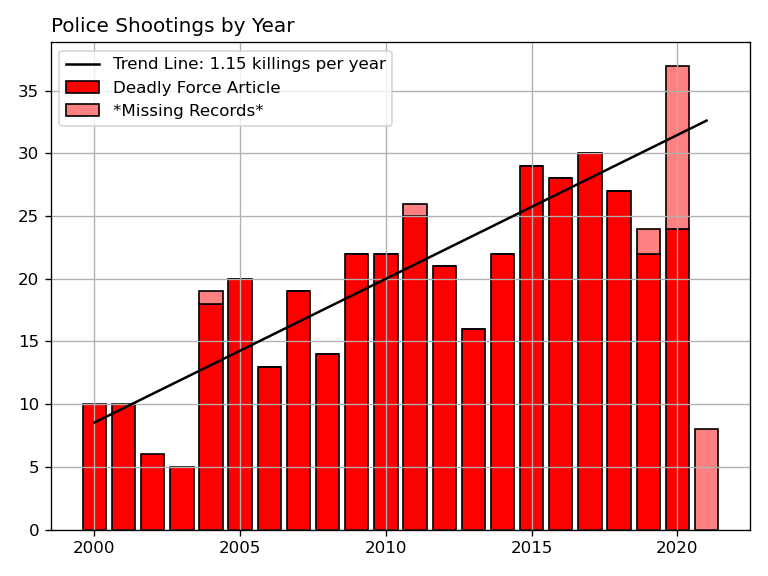

In [71]:
CA_Total=Data.CA_PoliceKillings['PROV'].count()
print('Total Police Killings in Canada: Jan 2000 - June 2020: '+str(CA_Total.sum()))
print(Data.CA_PoliceKillings.resample('YS').count()['PROV'].max())
ByYear=Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['CAUSE DEATH']=='Gunshot'].resample('YS').count()['PROV']

MonthlyMiss = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']=='Other'].resample('MS').count()['PROV']
print('Missing Recrods in CBC data: ',MonthlyMiss.loc[MonthlyMiss.index<'2020-07-01'].sum())

print('Incidetns since CBC data published: ',MonthlyMiss.loc[MonthlyMiss.index>='2020-07-01'].sum())


CBC_Article = Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']=='CBC Deadly Force')
                                          &
                                         (Data.CA_PoliceKillings['CAUSE DEATH']=='Gunshot')
                                         )
                                        ].resample('YS').count()['PROV']
Missing = Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')
                                      &
                                         (Data.CA_PoliceKillings['CAUSE DEATH']=='Gunshot')
                                     )
                                    ].resample('YS').count()['PROV']
print(CBC_Article.shape,
Missing.shape)
print(Missing)

LR = stats.linregress(ByYear.index.year[:-1],ByYear.values[:-1])
print(LR)


fig,ax=plt.subplots(1,1)
ax.set_title('Police Shootings by Year',loc='left')
ax.bar(CBC_Article.index.year,CBC_Article.values,
       color=[1,0,0],edgecolor='k',label='Deadly Force Article')
ax.bar(Missing.index.year,Missing.values,bottom = np.append(CBC_Article[4:].values,[0]),
       color=[1,0.5,0.5],edgecolor='k',label='*Missing Records*')
# ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k',label='Total Jan-Nov')
ax.plot(ByYear.index.year,ByYear.index.year*LR[0]+LR[1],
        color='k',label = 'Trend Line: '+str(np.round(LR[0],2))+' killings per year')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_Trendline.png')

In [53]:
ByRace = (Data.CA_PoliceKillings.groupby('RACE').count()['PROV'])
print(ByRace['Unknown']/ByRace.sum())

0.25166666666666665


<IPython.core.display.Javascript object>


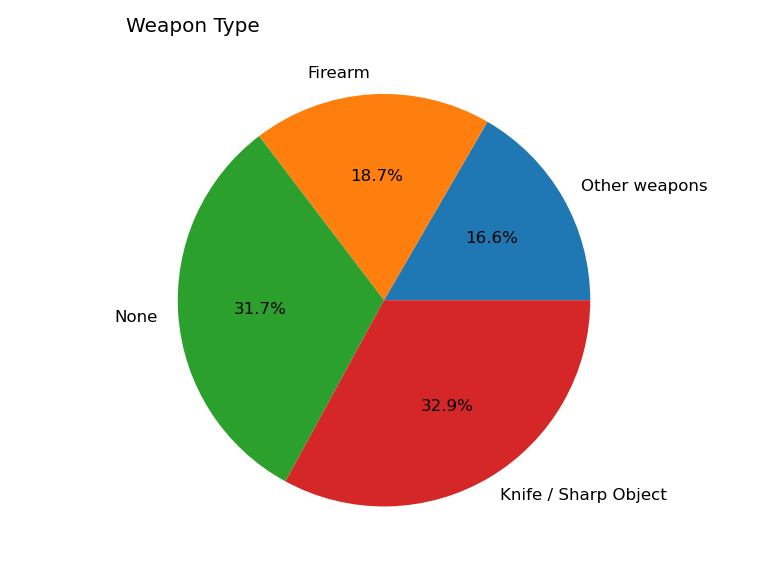

In [72]:
Weaopn_Type=Data.CA_PoliceKillings.groupby('ARMED TYPE').count()['AGE'].sort_values()

fig,ax=plt.subplots(1,1)
ax.set_title('Weapon Type',loc='left')
ax.pie(Weaopn_Type.values,labels=Weaopn_Type.index,
    autopct='%1.1f%%')
plt.tight_layout()
plt.savefig('Content/CA_Weapon.png')

In [55]:
Category = 'RACE'
Departments=Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV',Category]).count()['SUMMARY'].unstack()
Departments=Departments.reset_index().set_index('POLICE SERVICE')
Departments=Departments.fillna(value=0)
print(Departments.sort_values(by='Indigenous',ascending=False).head())

RACE                          PROV  Arab  Asian  Black  Indigenous  \
POLICE SERVICE                                                       
RCMP                            BC   0.0    2.0    0.0        14.0   
Winnipeg Police Service         MB   1.0    0.0    2.0        14.0   
RCMP                            AB   0.0    0.0    0.0        10.0   
RCMP                            NU   0.0    0.0    0.0         8.0   
Kativik Regional Police Force   QC   0.0    0.0    0.0         8.0   

RACE                           Latin American  South Asian  Unknown  \
POLICE SERVICE                                                        
RCMP                                      0.0          3.0     20.0   
Winnipeg Police Service                   0.0          0.0      1.0   
RCMP                                      0.0          0.0     17.0   
RCMP                                      0.0          0.0      0.0   
Kativik Regional Police Force             0.0          0.0      0.0   

RACE       

In [56]:



Departments['Total'] = Departments[Data.CA_PoliceKillings[Category].unique()].sum(axis=1)

Departments['NAME']=Departments.index
Departments['NAME']=Departments['NAME'].str.replace(' Department','')
Departments['NAME']=Departments['NAME'].str.replace(' Services','')
Departments['NAME']=Departments['NAME'].str.replace(' Service','')
Departments['NAME']=Departments['NAME'].str.replace(' Force','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de la Ville de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de la sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de ','')
Departments['NAME']=Departments['NAME'].str.replace('Régie intermunicipale de police ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Sécurité publique de ','')

Departments['City']=Departments['NAME'].str.replace('Ontario Provincial Police','')
Departments['City']=Departments['City'].str.replace(' Police','')
Departments['City']=Departments['City'].str.replace('RCMP','')
Departments['City']=Departments['City'].str.replace('Sûreté du Québec','')
Departments['City']=Departments['City'].str.replace(' Regional','')
Departments['City']=Departments['City'].str.replace('Royal Newfoundland Constabulary','')
Departments['City']=Departments['City'].str.replace(' Community','')
Departments['City']=Departments['City'].str.replace('South Coast British Columbia Transit Authority','')
Departments['City']=Departments['City'].str.replace("l'agglomération de ",'')
Departments['City']=Departments['City'].str.replace('du ','')

Departments['TYPE']='Municipal/Regional'
# Departments.loc[Departments.index.str.contains('Regional')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Toronto')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains("Service de police de l'agglomération de ")==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Transit Authority Police Service')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Régie intermunicipale de police')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Service de police de la Ville de Montréal')==True,'TYPE']='Regional'
Departments.loc[Departments.index.str.contains('RCMP')==True,'TYPE']='RCMP'
Departments.loc[Departments.index.str.contains('Ontario Provincial Police')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('OPP')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Sûreté du Québec')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Royal Newfoundland Constabulary')==True,'TYPE']='Provincial'

writer = pytablewriter.MarkdownTableWriter()
writer.table_name = "Deadliest Police Departments in Canada"
writer.header_list = ['Rank',"Department", "Province", "Killings"]
TB = Departments.loc[Departments['Total']>=10].sort_values(by='Total',ascending=False).reset_index()#[0:10]
writer.value_matrix = [[index+1,value['POLICE SERVICE'],value['PROV'],value['Total']]for index,value in TB.iterrows()]
# list(Departments.groupby('TYPE').count()['NAME'])
#     ["1", "AD", "Europe/Andorra"],
#     ["2", "AE", "Asia/Dubai"],
#     ["3", "AF", "Asia/Kabul"],
#     ["4", "AG", "America/Antigua"],
#     ["5", "AI", "America/Anguilla"],
# ]
# print(Departments.head())
writer.write_table()

print(Departments['Total'].count())
print(Departments.loc[Departments['Total']>=10,'Total'].sum())
print(Departments.loc[Departments['Total']>=10,'Total'].count())

print(Departments.loc[Departments['Total']>=10,'Total'].sum()/CA_Total.sum())

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total'])

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total']/CA_Total.sum())

# print(80/CA_Total.sum())


# Deadliest Police Departments in Canada
|Rank|               Department                |Province|Killings|
|---:|-----------------------------------------|--------|-------:|
|   1|RCMP                                     |BC      |      82|
|   2|Toronto Police Service                   |ON      |      58|
|   3|RCMP                                     |AB      |      38|
|   4|Service de police de la Ville de Montréal|QC      |      35|
|   5|Sûreté du Québec                         |QC      |      34|
|   6|Ontario Provincial Police                |ON      |      33|
|   7|Edmonton Police Service                  |AB      |      29|
|   8|Calgary Police Service                   |AB      |      27|
|   9|Vancouver Police Department              |BC      |      25|
|  10|Winnipeg Police Service                  |MB      |      21|
|  11|Peel Regional Police                     |ON      |      16|
|  12|Ottawa Police Service                    |ON      |      10|
|  13|York Regional P

In [57]:
from geopy.geocoders import MapBox
import geopandas as gpd
api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

geolocator = MapBox(api_key=api_key)

# print(Departments)

Departments['Lat']=np.nan
Departments['Lon']=np.nan
Departments['Geocoding_notes']=''

for index,Service in Departments.sort_values(by='Total',ascending=False).iterrows():
    try:
        if Service.TYPE=='Municipal/Regional':
            Point = geolocator.geocode(Service.NAME+', '+Service.City+', '+Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
            Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
        else:
            Point = geolocator.geocode(Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
            Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
    except:
        Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),'Geocoding_notes']='Geocoding Failed'
        pass



Departments_GPD = gpd.GeoDataFrame(Departments,
    geometry=gpd.points_from_xy(Departments.Lon,
                                Departments.Lat
                               ) )

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
Departments_GPD.crs = WGS_1984
Departments_GPD = Departments_GPD.to_crs(Data.CA.crs)
print('Done')

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Done


In [58]:
print(Departments.loc[Departments['Geocoding_notes']=='Geocoding Failed'])

Empty DataFrame
Columns: [PROV, Arab, Asian, Black, Indigenous, Latin American, South Asian, Unknown, Visible minority, n.i.e, White, Total, NAME, City, TYPE, Lat, Lon, Geocoding_notes, geometry]
Index: []


In [59]:
# from geopy.geocoders import MapBox
import folium
# # from IPython.display import clear_output

# api_key = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

def plot_point(Map,X,Y,Popup_Text,Color='olive',Radius=5,Opacity=.75,LineColor='black',LineWidth=.15):
    folium.CircleMarker(
        # The coordiatnates
        location=[X,Y],
        # Text description
        popup=Popup_Text,
        # sets the fill color for the point
        fill_color=Color,
        # Size of the marker
        radius=Radius,
        # Opacity of the circle
        fill_opacity = Opacity,
        # Sets the line color for the edge
        color=LineColor,
        # Width of the border line
        line_weight=LineWidth,
    ).add_to(Map)

Scale,Offset=.5,1
    
Final_Map = folium.Map(
    location=[60,-91.5],
    zoom_start=3,
    tiles='Stamen Toner'
)

group0 = folium.FeatureGroup(name='RCMP')
group1 = folium.FeatureGroup(name='Provincial Police Forces')
group2 = folium.FeatureGroup(name='Municipal/Regional Police Forces')
Cats=Data.CA_PoliceKillings['RACE'].unique()
for index, row in Departments_GPD.iterrows():
#     if row['geocoding_Notes'] != 'Geocoding Failed':
        
        # ''' indicates we're wrting multiline strings
        # We'll write the header and the top row of the table
        popuptext='''<body> <h2>'''+index+'''</h2> 
                    <table style="width:100%">
                    <tr>
                    <th>Race</th>
                    <th>Number of Killings &nbsp </th>
                    <th>Percentage of Total</th>
                    </tr>
                     '''
        
        # We'll sort each row by race so the largest appears at the top of the table
        Sorted = row[Cats].sort_values(ascending=False)
        for i,v in zip(Sorted.index,Sorted.values):
            if (np.isnan(v)==False) and (v>0):
                if np.isnan(v)==False:
                    # If the value for a race exists, we'll add it to the table
                    popuptext+= '''<tr>
                                <td>'''+i+''' &nbsp </td>
                                <td>'''+str(int(v))+'''</td>
                                <td>'''+str(int(v/row['Total']*100))+'''%</td>
                                </tr>'''
    #         We'll add row at the bottom of the table with the total


        popuptext+='''<tr>
                      <th>Total </th>
                      <th>'''+str(row['Total'])+'''</th>
                      <th> </th>
                      </tr>'''
        
        # We'll convert the text tot html
        test = folium.Html(popuptext, script=True)
#         folium.
        
        # This defines the parameters for the popup text box
        popup = folium.Popup(test, max_width=400,min_width=300)
        
#         # Now we can send the popup to the CircleMarker
        if row['TYPE']=='RCMP':
            plot_point(Map=group0,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#FF0000',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
            
        elif row['TYPE']=='Provincial':
            plot_point(Map=group1,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#9400D3',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
        else:
            plot_point(Map=group2,
                   X=row.Lat,#['latitude'],
                   Y=row.Lon,#['longitude'],
                   Popup_Text=popup,
                   # This is hexcode for the official red of Canada
                   Color='#0000ff',
                   # We'll scale the radius by the number of killings + 2
                   Radius=(row['Total'])*Scale+Offset,
                  )
group0.add_to(Final_Map)


group2.add_to(Final_Map)


group1.add_to(Final_Map)
    
folium.LayerControl().add_to(Final_Map)
    
Final_Map.save('Content/PoliceViolenceIncidents.html')
Final_Map

VICTIM ID         151
DATE              150
NAME FIRST        151
NAME LAST          99
NAME MIDDLE        41
NICKNAME            3
AGE               139
GENDER            151
RACE              151
PROV              151
POLICE SERVICE    151
Second              2
Third               0
CAUSE DEATH       151
ARMED TYPE        151
DATA SOURCE       151
Link              151
SUMMARY           149
Year              150
dtype: int64
0.034096332333932486
                                0
Black                     1198545
Asian                     3216380
Unknown                         0
Indigenous                1673780
White                    25803358
Visible minority, n.i.e    364460
South Asian               1924640
Arab                       523235
Latin American             447330


<IPython.core.display.Javascript object>


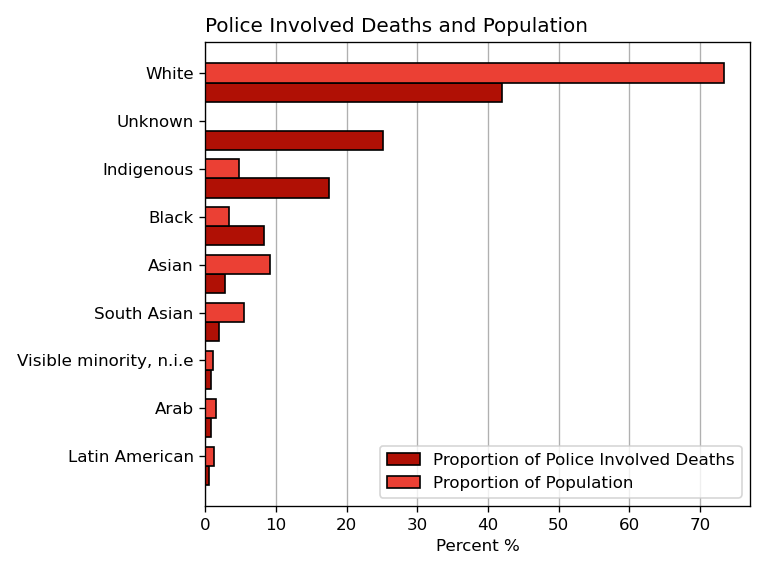

                             PROV         0
RACE                                       
Latin American           0.005000  0.012726
Arab                     0.008333  0.014885
Visible minority, n.i.e  0.008333  0.010368
South Asian              0.020000  0.054752
Asian                    0.028333  0.091500
Black                    0.083333  0.034096
Indigenous               0.175000  0.047616
Unknown                  0.251667  0.000000
White                    0.420000  0.734057


<IPython.core.display.Javascript object>


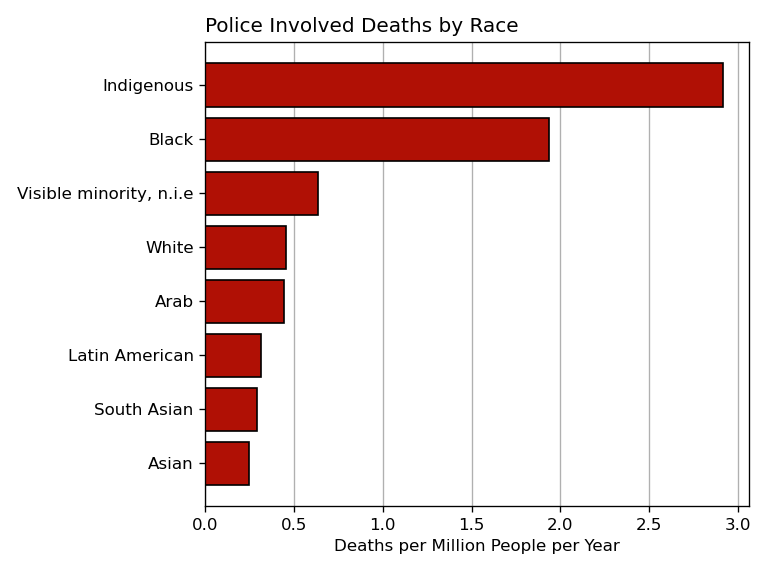

                         PROV         0      Norm
RACE                                             
Asian                      17   3216380  0.245612
South Asian                12   1924640  0.289734
Latin American              3    447330  0.311646
Arab                        5    523235  0.444059
White                     252  25803358  0.453829
Visible minority, n.i.e     5    364460  0.637511
Black                      50   1198545  1.938578
Indigenous                105   1673780  2.915135
0.8128029601113372
600


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


In [63]:
print(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['RACE']=='Unknown'].count())
print(Data.CA.sum()['Black']/Data.CA.sum()['Total'])

Races = (Data.CA_PoliceKillings['RACE'].unique())
Pop = Data.CA[Races].sum().to_frame()
print(Pop)


fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Police Involved Deaths and Population',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=(ByRace/ByRace.sum()).to_frame()
ByRace = ByRace.join(Pop/Pop.sum(),lsuffix='_Pop')
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values*100,color='#b01005',edgecolor='k',
        height=.4,label='Proportion of Police Involved Deaths',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace[0].values*100,color='#eb4034',edgecolor='k',
        height=.4,label='Proportion of Population',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.set_xlabel('Percent %')
ax.legend()
plt.tight_layout()

plt.savefig('Content/CA_Race_Proportional.png')


fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Police Involved Deaths by Race',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=ByRace.to_frame()
ByRace = ByRace.join(Pop,lsuffix='_Pop')
ByRace['Norm']=ByRace['PROV'].values/ByRace[0].values*1e6/Data.CA_Length
ByRace=ByRace.sort_values(by='Norm')[:-1]
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
# ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values,color='#b01005',edgecolor='k',
#         height=.4,label='Proportion of Police Killings',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace['Norm'],color='#b01005',edgecolor='k',
        height=.8,label='Proportion of Population',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.set_xlabel('Deaths per Million People per Year')
# ax.legend()
plt.tight_layout()

plt.savefig('Content/CA_Race_Normalized.png')



print(CA_Total.sum()/Data.CA.Total.sum()/21*1e6)
# print(Data.CA.Total.sum())
print(CA_Total.sum())

In [70]:
print(ByRace)
from scipy.stats import chisquare
print(ByRace.index)
# R = ['Indigenous','White','Black','Arab','Asian']
R = ByRace.index.values#.drop('Unknown').values
Dept = ['Winnipeg Police Service','Vancouver Police Department','Toronto Police Service','Calgary Police Service','Edmonton Police Service']
City = ['Winnipeg','Vancouver','Toronto','Calgary','Edmonton']
FOBS = []
FEXP = []
for D,C in zip(Dept,City):
    F_obs = Departments_GPD.loc[Departments_GPD.index == D,R].values.flatten()
    F_exp = Data.Municipal_Boundaries.loc[Data.Municipal_Boundaries['Name'] == C,R].values.flatten()
    F_exp = F_exp/F_exp.sum()*Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']==D,'GENDER'].count()#F_obs.sum()
    
    FOBS.append(F_obs)
    FEXP.append(F_exp)
#     print(F_exp)
    res = chisquare(F_obs, f_exp=F_exp)
    print(C,F_obs.sum(),res[1])

# print(Data.CA['PREABBR'])
# print(Data.CA['PREABBR'])
# Data.CA.head()
P = Departments_GPD['PROV'].unique()
# P2 = ['B.C.','B.C.']

R2 = [r+'_Killings'for r in R]
for p in P:
    try:
        F_obs = Data.CA.loc[((Data.CA.index ==  p)),
                                    R2].fillna(0).values.flatten()
        F_exp = Data.CA.loc[Data.CA.index== p,R].fillna(0).values.flatten()
        F_exp = F_exp/F_exp.sum()*F_obs.sum()
        FOBS.append(F_obs)
        FEXP.append(F_exp)
#         print(F_obs,F_exp)
        res = chisquare(F_obs, f_exp=F_exp)
        print(p,F_obs.sum(),res[1])
        
    except:
        pass

print('UKN',Data.CA['Unknown_Killings'].sum())

F_obs=Data.CA[R2].fillna(0).sum().values
F_exp=Data.CA[R].fillna(0).sum().values

F0 = F_exp.tolist()
print(F_exp)
F0.append(F_exp.sum())
F0.append(0)
F_exp = F_exp*(Data.CA_PoliceKillings.count().RACE/F_exp.sum())

print()
res = chisquare(F_obs, f_exp=F_exp)
print(res)
R = R.tolist()
R.append('Total')

R = np.append(R,'Unknown')

F1 = F_exp.tolist()
F1.append(F_exp.sum())
F1.append(0)
F2 = F_obs.tolist()
F2.append(Data.CA_PoliceKillings.count().RACE)
F2.append(Data.CA['Unknown_Killings'].sum())
print('F2',F2)

from tabulate import tabulate
d = {"By Race": ["Total Population (Millions)", "Expected Distribtuion", "Observed Distribution"]}
for i,r in enumerate(R):
    d[r]=[int(F0[i]/1e5)/10,int(F1[i]),int(F2[i])]
df = pd.DataFrame(d).set_index("By Race")
df = df.T.sort_values(by='Total Population (Millions)',ascending=False).T
# df.loc[df.index!='Observed Killings','Unknown']='--'


print(tabulate(df.T, tablefmt="pipe", headers="keys"))
print(Data.CA['Total_Killings'].sum()/Data.CA['Total'].sum()*1e6/21)
print(Data.CA['Total_Killings'].sum())
print(Data.CA_PoliceKillings.count())

T = (Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['RACE']=='Unknown'].groupby('POLICE SERVICE').count()['GENDER'].sort_values())

print(T/T.sum())

                         PROV         0      Norm
RACE                                             
Asian                      17   3216380  0.245612
South Asian                12   1924640  0.289734
Latin American              3    447330  0.311646
Arab                        5    523235  0.444059
White                     252  25803358  0.453829
Visible minority, n.i.e     5    364460  0.637511
Black                      50   1198545  1.938578
Indigenous                105   1673780  2.915135
Index(['Asian', 'South Asian', 'Latin American', 'Arab', 'White',
       'Visible minority, n.i.e', 'Black', 'Indigenous'],
      dtype='object', name='RACE')
Winnipeg 20.0 2.359879704184608e-12
Vancouver 16.0 0.005393366299093598
Toronto 43.0 3.676653498562747e-10
Calgary 20.0 0.025706270417982395
Edmonton 19.0 0.015212985775639757
BC 86.0 1.9621374012727457e-06
ON 143.0 2.4021578320020577e-28
QC 84.0 1.3461659481051927e-11
NB 5.0 0.01565901751250399
AB 63.0 4.572676542345333e-11
NS 7.0 0.98551

<IPython.core.display.Javascript object>


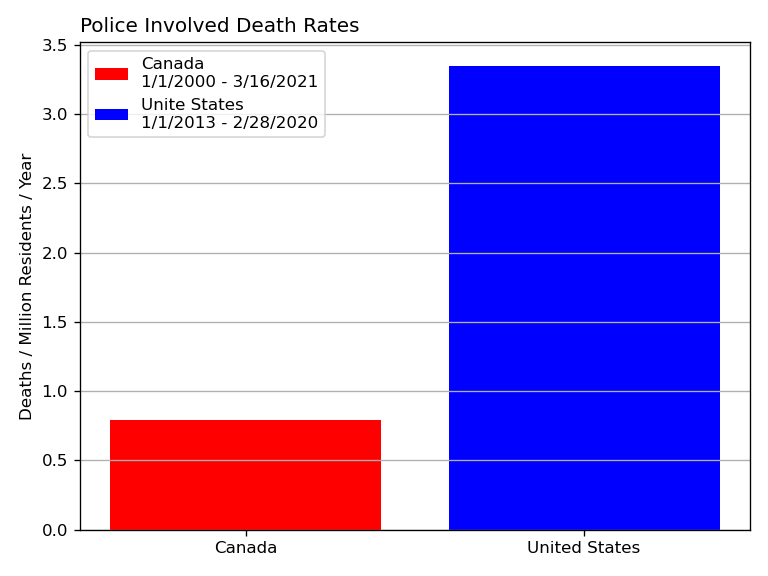

4.22438500090963


In [73]:
US_Total=Data.US_PoliceKillings["State"].count()

CA_Rate = CA_Total /(Data.CA.Total.sum()*Data.CA_Length) * 1e6
US_Rate = US_Total /(Data.US.Total.sum()*Data.US_Length) * 1e6

fig,ax=plt.subplots()
ax.bar([0],CA_Rate,color=[1,0,0],label='Canada\n1/1/2000 - 3/16/2021')
ax.bar([1],US_Rate,color=[0,0,1],label='Unite States\n1/1/2013 - 2/28/2020')
ax.set_xticks([0,1])
ax.set_xticklabels(['Canada','United States'])
ax.set_title('Police Involved Death Rates',loc='left')
ax.set_ylabel('Deaths / Million Residents / Year')
ax.legend()


ax.grid(axis='y')
ax.legend()
plt.tight_layout()
plt.savefig('Content/NormalizedComparison.png')

print(US_Rate/CA_Rate)

['Black' 'Asian' 'Unknown' 'Indigenous' 'White' 'Visible minority, n.i.e'
 'South Asian' 'Arab' 'Latin American']
['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total

<IPython.core.display.Javascript object>


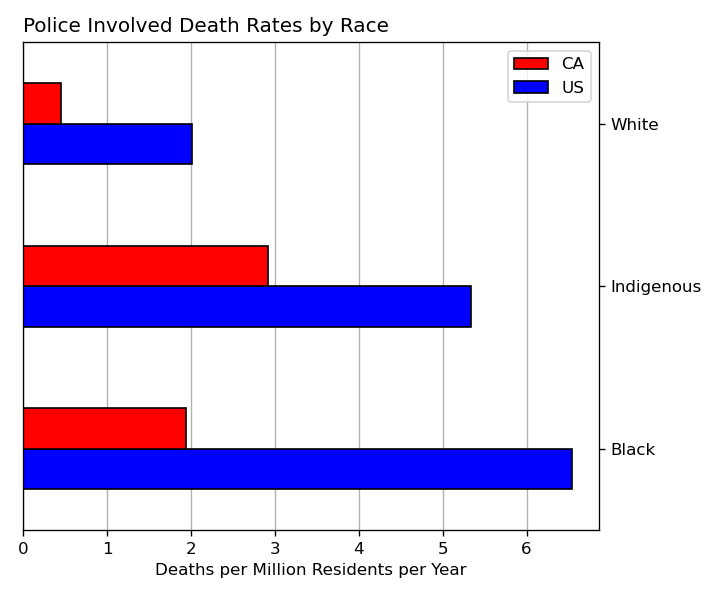

In [74]:
print(Data.CA_PoliceKillings['RACE'].unique())
# print(Data.Combined)

Data.ScaleData(scale=1e6)
print('Police Killing Rates:')
# print(Data.Summary)
Data.Summary = Data.Summary.dropna()
Temp = Data.Summary.loc[((Data.Summary.index!='Asian')&(Data.Summary.index!='Total'))]

fig,ax=plt.subplots(figsize=(6,5))
Temp[['US','CA']].plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder=2)
ax.set_title('Police Involved Death Rates by Race',loc='left')
ax.set_xlabel('Deaths per Million Residents per Year')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])


plt.tight_layout()
plt.savefig('Content/Racial_Comparison.png')


                  US        CA
Black       1.959571  2.444056
Indigenous  1.600436  3.675245
White       0.600986  0.572163


<IPython.core.display.Javascript object>


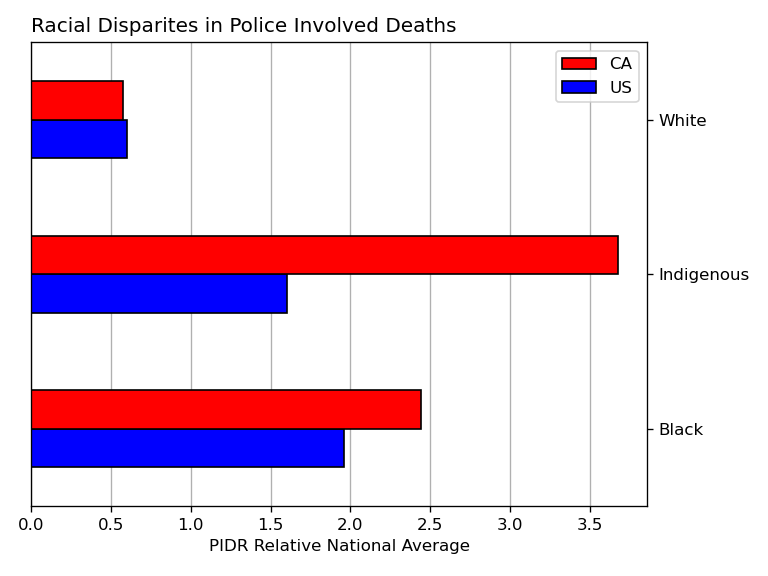

In [75]:
Ratio = Data.Summary.loc[Data.Summary.index=='Black']/Data.Summary.loc[Data.Summary.index=='Total'].values
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='Indigenous']/Data.Summary.loc[Data.Summary.index=='Total'].values)
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='White']/Data.Summary.loc[Data.Summary.index=='Total'].values)


print(Ratio)
fig,ax=plt.subplots()
Ratio.plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder = 2)
ax.set_title('Racial Disparites in Police Involved Deaths',loc='left')
ax.set_xlabel('PIDR Relative National Average')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])


plt.tight_layout()
plt.savefig('Content/Racial_Disparities.png')


In [87]:

Data.ScaleData(scale=1e6)
Rate='Total'
Data.Breaks(column=Rate+'_Rate',classes=5,Manual_Bins=[0,1,2,5,10,15])

Data.US=Data.US.to_crs(Data.CA.crs)

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


<IPython.core.display.Javascript object>


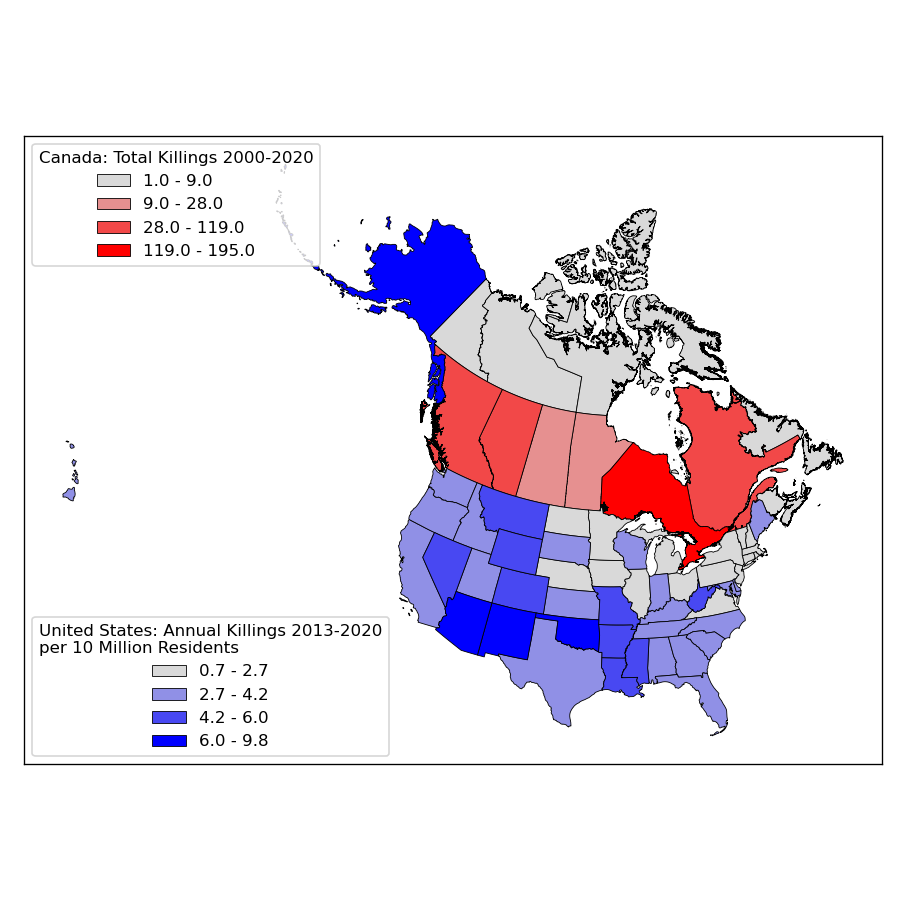

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Legend does not support Text(0, 0, 'Canada') instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


In [93]:
Rate = 'Total'
n_classes=4

Data.ScaleData(scale=1e6)

Data.Breaks(column='Total_Killings',classes=n_classes,Manual_Bins=[1,4,7,91,175])
Data.US=Data.US.to_crs(Data.CA.crs)

labels=Data.CA[Rate+'_Killings_NB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = [matplotlib.text.Annotation('Canada',(0,0))]
for i,klass in enumerate(Data.CA[Rate+'_Killings_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':CA_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.CA_jenks[i],1))+' - '+str(np.round(Data.CA_jenks[i+1],1))}
    if Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].count()['PRNAME']>0:
        Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))

Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

labels=Data.US[Rate+'_Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

US_Patches = []
# US_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'United States'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.US_jenks[i],1))+' - '+str(np.round(Data.US_jenks[i+1],1))}
    Data.US.loc[Data.US[Rate+'_Rate_NB']==klass].plot(
        ax=ax,
        **kwargs
             )
    US_Patches.append(mpatches.Patch(**kwargs))
first_legend = plt.legend(handles=CA_Patches, loc='upper left',
      title='Canada: Total Killings 2000-2020')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

# Create another legend for the second line.
ax.legend(handles=(US_Patches), loc='lower left',
      title='United States: Annual Killings 2013-2020\nper 10 Million Residents')
    
# ax.legend(handles={'PKR':Patches},) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_title('Police Killings')

plt.tight_layout()
plt.savefig('Content/IsItNormalalized_Map.png',bbox_inches='tight')

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Unknown_Killings', 'Unknown_Rate', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']
[(-0.001, 1.0], (1.0, 2.0], (2.0, 5.0], (5.0, 10.0], (10

<IPython.core.display.Javascript object>


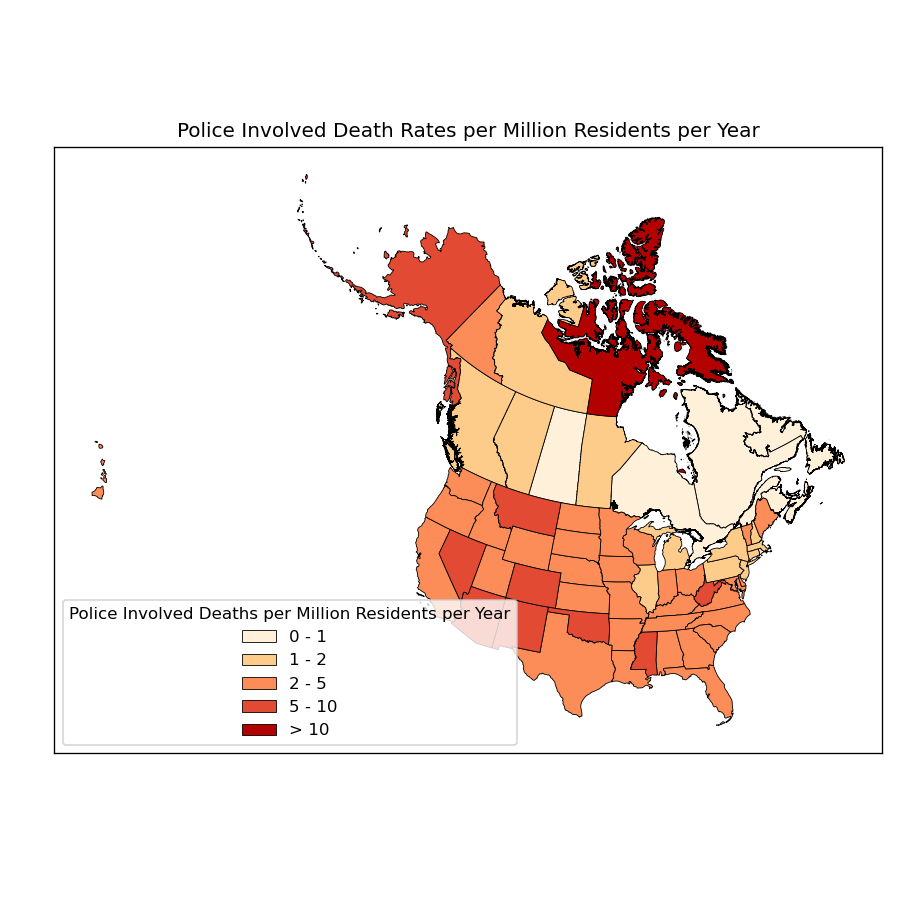

<IPython.core.display.Javascript object>


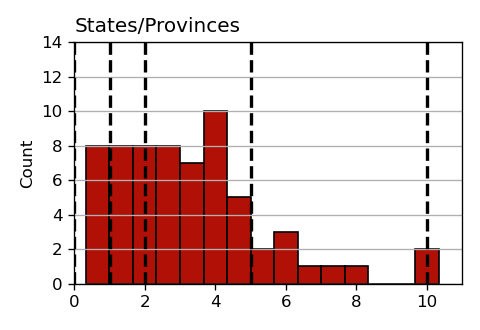

    Total_Rate  Total_Rate_MB
NL    0.357653  (-0.001, 1.0]
SK    0.930784  (-0.001, 1.0]
ON    0.673796  (-0.001, 1.0]
QC    0.597633  (-0.001, 1.0]
RI    0.695771  (-0.001, 1.0]
..         ...            ...
NV    6.020524    (5.0, 10.0]
AZ    6.838500    (5.0, 10.0]
CO    5.876864    (5.0, 10.0]
MT    5.886277    (5.0, 10.0]
NU   10.342636   (10.0, 15.0]

[64 rows x 2 columns]
[(-0.001, 1.0], (1.0, 2.0], (2.0, 5.0], (5.0, 10.0], (10.0, 15.0]]
Categories (5, interval[float64]): [(-0.001, 1.0] < (1.0, 2.0] < (2.0, 5.0] < (5.0, 10.0] < (10.0, 15.0]]


In [98]:

Data.ScaleData(scale=1e6)
Rate = 'Total'
n_classes=5
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,1,2,5,10,15])


labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()
print(labels)

colors=['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
Combined_Color = {key:value for key,value in zip(labels,colors)}
Combined_Color = {key:value for key,value in zip(labels,colors)}

ig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []
labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()

for i,klass in enumerate(Data.Combined[Rate+'_Rate_MB'].unique().sort_values()):
#     try:
#     print(i)
    if i == 4:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':'> '+str(np.round(Data.Manual_Bins[i],1))}
    else:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.Manual_Bins[i],1))+' - '+str(np.round(Data.Manual_Bins[i+1],1))}
#     print(Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].index)
    Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].plot(
        ax=ax,
        **kwargs
             )
    Combined_Patches.append(mpatches.Patch(**kwargs))
#     except:
#         pass
    
#     print(Combined_Patches)
ax.legend(handles=(Combined_Patches), loc='lower left',title='Police Involved Deaths per Million Residents per Year')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Police Involved Death Rates per Million Residents per Year')

plt.savefig('Content/ManualBreaks_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k')

for v in Data.Manual_Bins:
    ax.axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')


ax.set_title('States/Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/ManualBreaks_Hist.png')

print(Data.Combined[[Rate+'_Rate',Rate+'_Rate_MB']].sort_values(by=Rate+'_Rate_MB'))
print(Data.Combined[Rate+'_Rate_MB'].unique().sort_values())

In [99]:
All = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().T
Data.CA['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.CA.loc[Data.CA.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.CA['Top'])


All = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().T
Data.US['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.US.loc[Data.US.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.US['Top'])


R = ['White','Black','Indigenous','Latin American','Hispanic','Pacific Islander']
Tempp = Data.Combined.copy()
for r in R:
    Tempp.loc[((Tempp[r]/Tempp['Total']<=.025)&(Tempp[r+'_Killings']<=2)),r+'_Rate']=np.nan
#     Tempp.loc[Tempp[r]<=5e3,r+'_Rate']=np.nan

Max = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']].max(axis=1)
Temp = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']]
# print(Temp.loc[Temp==Max])
Data.Combined['Top']=''
for index,row in Temp.iterrows():
#     print()
    Data.Combined.loc[Data.Combined.index==index,'Top']=row.loc[row==Max[index]].index.values[0].split('_')[0]
# print(Max
# print(Data.Combined['Top'])
# print(Data.Combined[['White_Rate','Black_Rate','Indigenous_Rate']])
print(Data.Combined[['Pacific Islander','Pacific Islander_Rate','Black_Rate','Pacific Islander_Killings','Top']].sort_values(by='Pacific Islander').dropna())

    Pacific Islander  Pacific Islander_Rate  Black_Rate  \
ID            2763.0              44.375048   10.153893   
OK            3859.0              31.772028   23.867013   
MI            3907.0              31.381689    4.274699   
PA            5008.0              24.482480    5.493486   
MO            7385.0              33.204674   14.100367   
AK            7958.0              15.406919   19.463945   
NC           10218.0              11.999242    4.689110   
UT           29362.0               8.351492   27.337404   
WA           53924.0              11.368617   13.025195   
HI          144971.0              20.297840    4.328623   
CA          155739.0               7.872675   11.005404   

    Pacific Islander_Killings               Top  
ID                        1.0        Indigenous  
OK                        1.0             Black  
MI                        1.0             Black  
PA                        1.0             Black  
MO                        2.0            

['White' 'Indigenous' 'Unknown']
['Black' 'White' 'Hispanic' 'Pacific Islander']


<IPython.core.display.Javascript object>


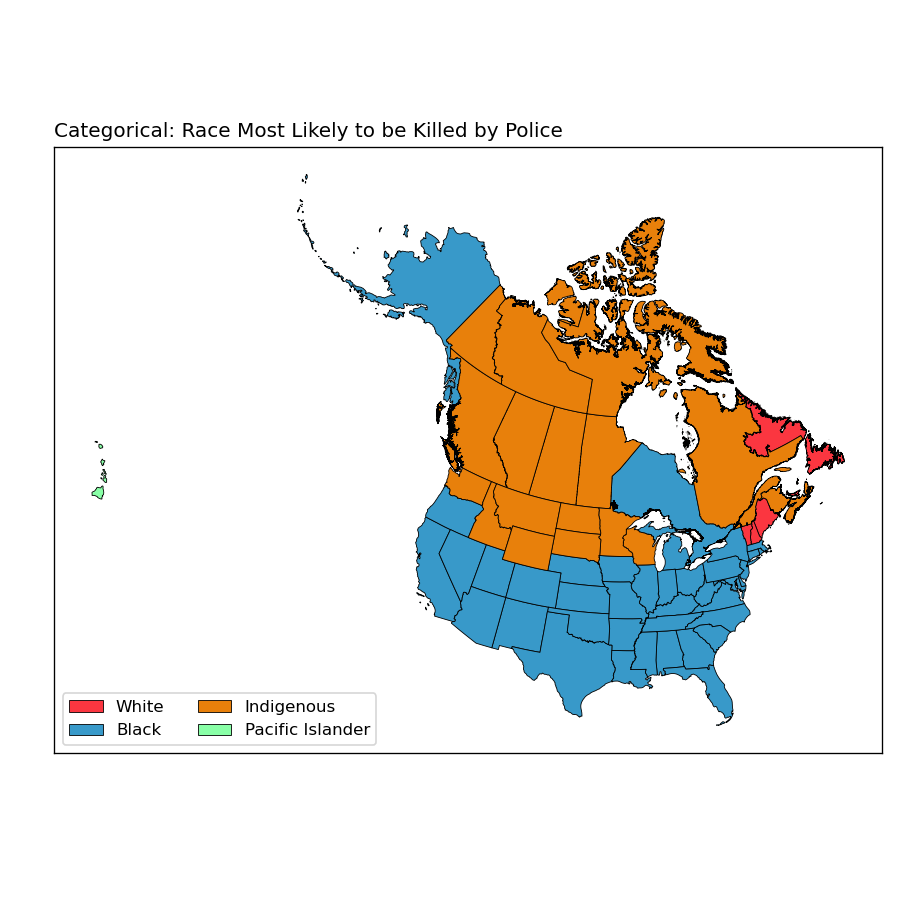

<IPython.core.display.Javascript object>


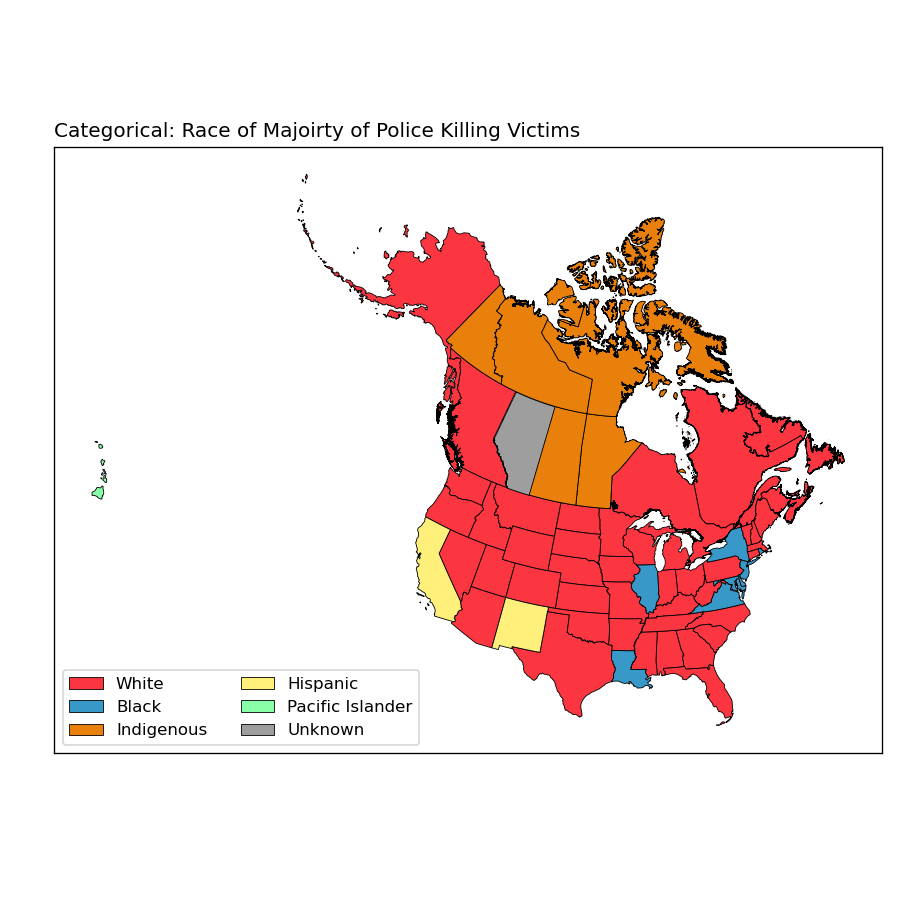

In [101]:
print(Data.CA['Top'].unique())
print(Data.US['Top'].unique())
RaceColor={'White':'#FB3640',
           'Black':'#3899C9',
           'Indigenous':'#E8800B',
           'Hispanic':'#FFF07C',
           'Pacific Islander':'#89FFA7',
            'Unknown':'#9e9e9e'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
   #str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.Combined.loc[Data.Combined['Top']==klass].count().Total_Killings>0:
        kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
        Data.Combined.loc[Data.Combined['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
        CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Categorical: Race Most Likely to be Killed by Police',loc='left')

plt.savefig('Content/HighestRateRace_Map.png',bbox_inches='tight')

# RaceColor={'White':'#FB3640',
#            'Black':'#3899C9',
#            'Indigenous':'#E8800B',
#            'Hispanic':'#FFF07C',
#            'Pacific Islander':'#89FFA7'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
    kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}#str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.CA.loc[Data.CA['Top']==klass].count().Total_Killings>0:
        Data.CA.loc[Data.CA['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
    if Data.US.loc[Data.US['Top']==klass].count()['State']>0:
    
        Data.US.loc[Data.US['Top']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Categorical: Race of Majoirty of Police Killing Victims',loc='left')

plt.savefig('Content/MostNumerousRace_Map.png',bbox_inches='tight')


https://bccla.org/wp-content/uploads/2012/03/2012-BCCLA-Report-Police-Involved-Deaths3.pdf